In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overriding 

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '05_27_24_SW_SoftVols'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Error loading result log file: [Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/05_27_24_SW_SoftVols/ACDC_Ensemble_Uncalibrated/submitit/679050_0_result.pkl'
Error loading result log file: [Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/05_27_24_SW_SoftVols/WBC_Ensemble_Uncalibrated/submitit/679486_0_result.pkl'
Error loading result log file: [Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/05_27_24_SW_SoftVols/PanDental_Jaw_Ensemble_Uncalibrated/submitit/679132_0_result.pkl'
Error loading result log file: [Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/05_27_24_SW_SoftVols/SpineWeb_Ensemble_Uncalibrated/submitit/644591_0_result.pkl'
Error loading result log file: [Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/05_27_24_SW_SoftVols/PanDental_Mandible_Ensemble_Uncalibrated/submitit/679250_0_result.pkl'
Dropping (datapoint, metric) pairs with NaN metri

In [4]:
# We want to compare how Dice relates to ECE, this means we need to pivot our dataframe
inference_df_piv = inference_df.pivot(index=['exp_name', 'dataset_name', 'data_id', 'sup_idx', 'pred_hash'], columns='image_metric', values='metric_score').reset_index()

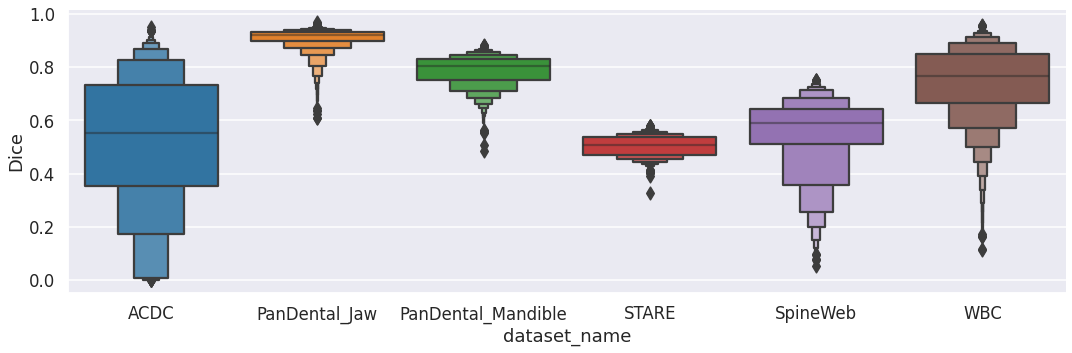

In [5]:
sns.catplot(
    data=inference_df_piv,
    x='dataset_name',
    y='Dice',
    kind='boxen',
    errorbar='sd',
    height=5,
    aspect=3,
    legend_out=False,
)

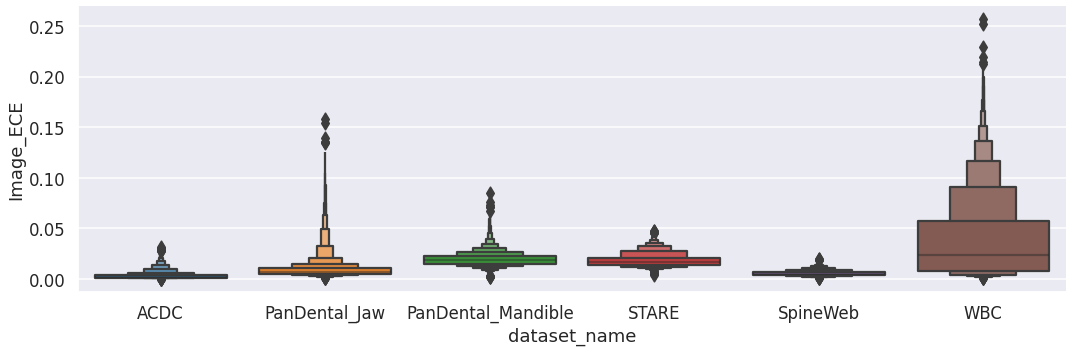

In [6]:
sns.catplot(
    data=inference_df_piv,
    x='dataset_name',
    y='Image_ECE',
    kind='boxen',
    errorbar='sd',
    height=5,
    aspect=3,
    legend_out=False,
)

In [7]:
inference_df_piv.keys()

Index(['exp_name', 'dataset_name', 'data_id', 'sup_idx', 'pred_hash',
       'Accuracy', 'BoundaryIOU', 'Dice', 'Dice Loss', 'HD95',
       'HardVolumeError', 'Image_CW-ECE', 'Image_ECE', 'Image_ECW-ECE',
       'Image_Edge-ECE', 'Image_Uniform-CW-ECE', 'Image_Uniform-ECW-ECE',
       'SoftVolumeError'],
      dtype='object', name='image_metric')

In [8]:
# Melt the dataframe
inference_df_melted = pd.melt(inference_df, id_vars=['data_id', 'sup_idx', 'pred_hash', 'dataset_name'], value_vars=['gt_volume', 'soft_volume', 'hard_volume'], var_name='Volume_Type', value_name='Volume')

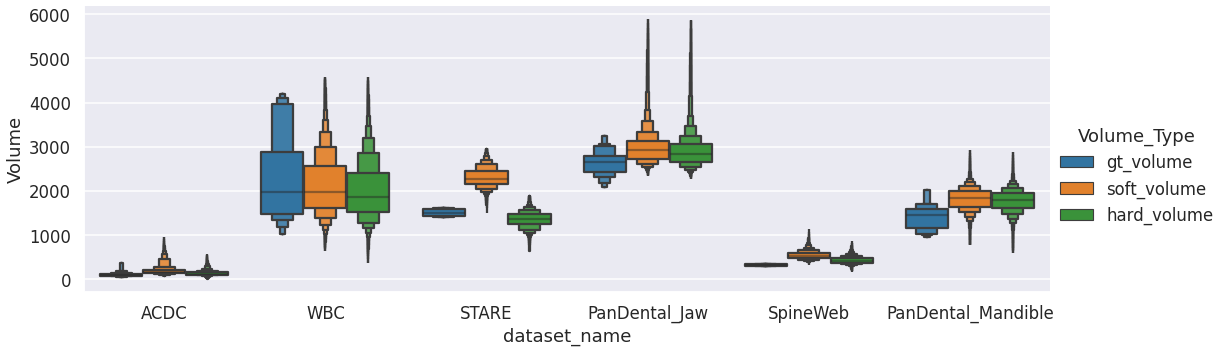

In [9]:
sns.catplot(
    data=inference_df_melted,
    x='dataset_name',
    y='Volume',
    hue='Volume_Type',
    kind='boxen',
    errorbar='sd',
    height=5,
    aspect=3,
    legend_out=True,
)


In [10]:
# Melt the dataframe
inference_df_piv_melted = pd.melt(inference_df_piv, id_vars=['data_id', 'sup_idx', 'pred_hash', 'dataset_name', 'Image_ECE'], value_vars=['SoftVolumeError', 'HardVolumeError'], var_name='Pred_Type', value_name='Measurement_Error')

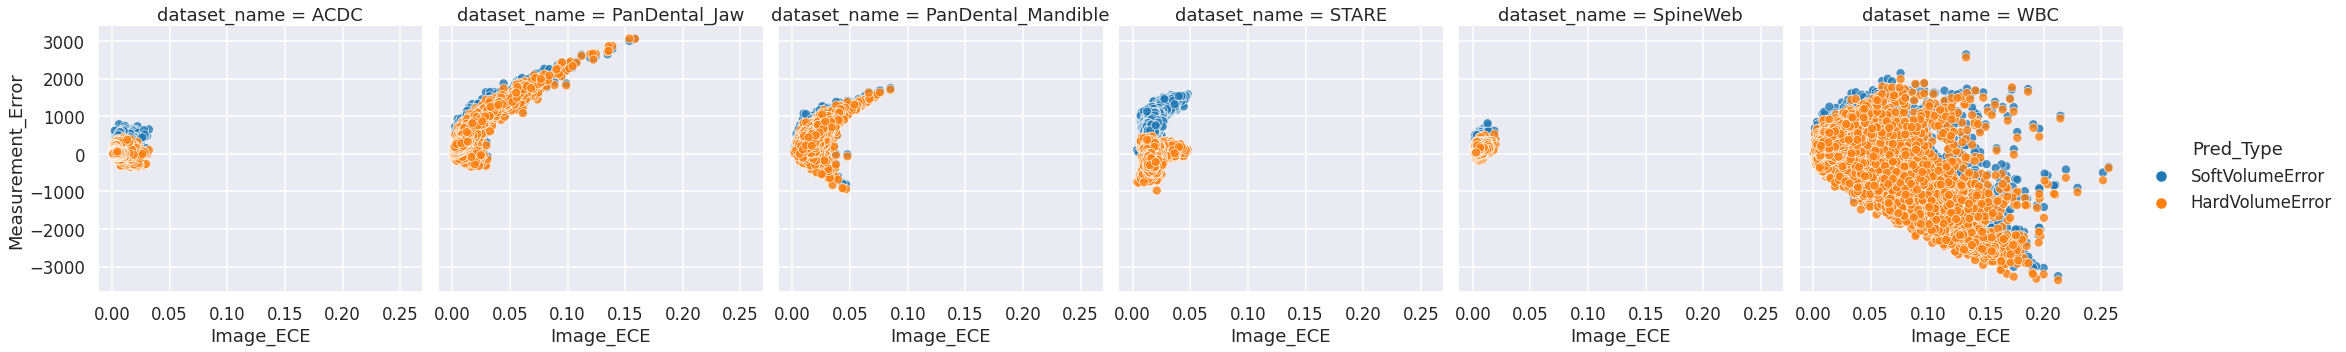

In [11]:
sns.relplot(
    data=inference_df_piv_melted,
    x='Image_ECE',
    y='Measurement_Error',
    hue='Pred_Type',
    col='dataset_name',
    height=5,
    alpha=0.8,
)

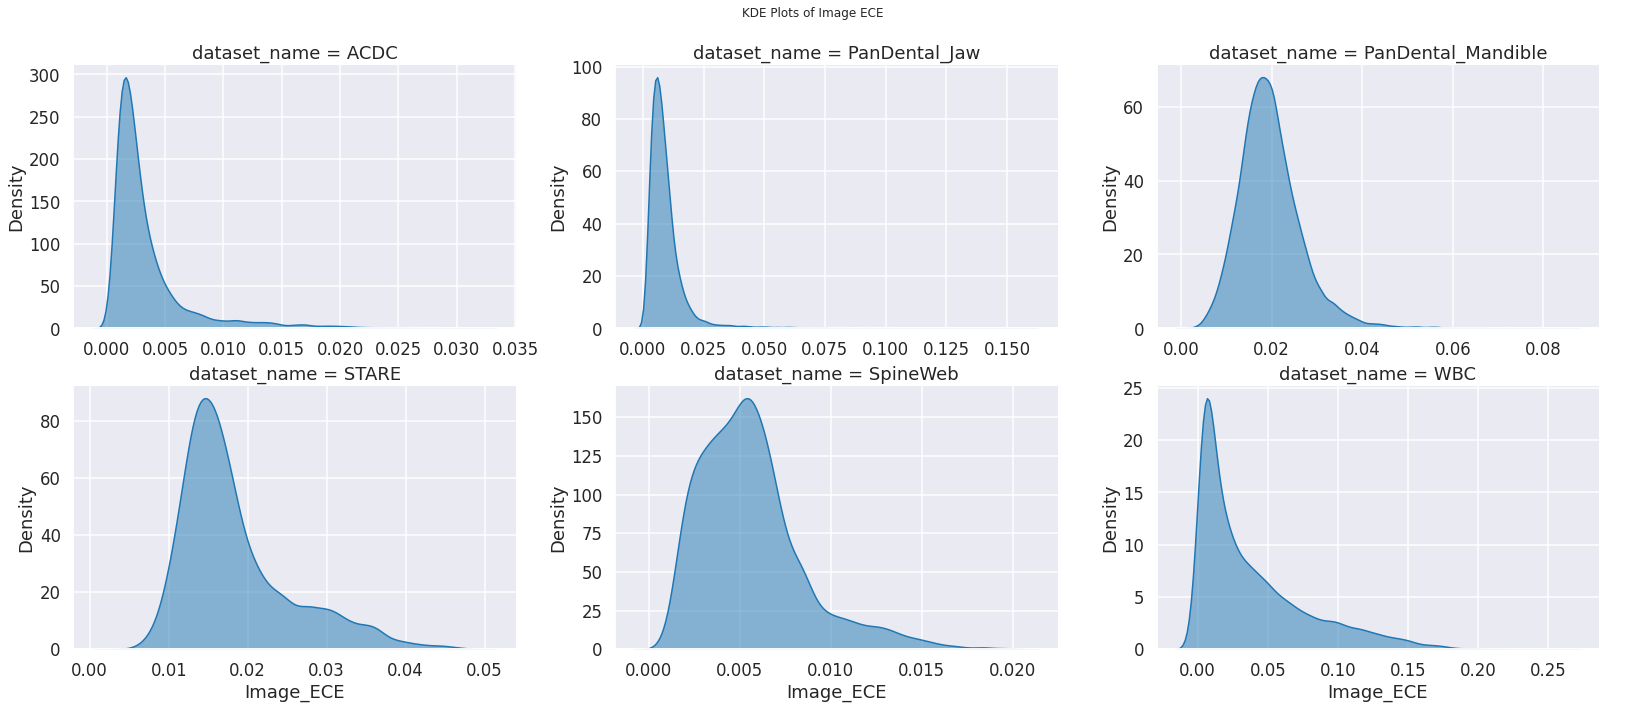

In [12]:
# Create a FacetGrid with dataset_name as columns
g = sns.FacetGrid(
    inference_df_piv_melted, 
    col='dataset_name', 
    col_wrap=3,
    height=5, 
    aspect=1.5, 
    sharex=False, 
    sharey=False
)

# Map the KDE plot to the grid
g.map(sns.kdeplot, 'Image_ECE', fill=True, alpha=0.5)

# Add a legend
g.add_legend()

# Adjust the layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('KDE Plots of Image ECE')

# Show the plot
plt.show()

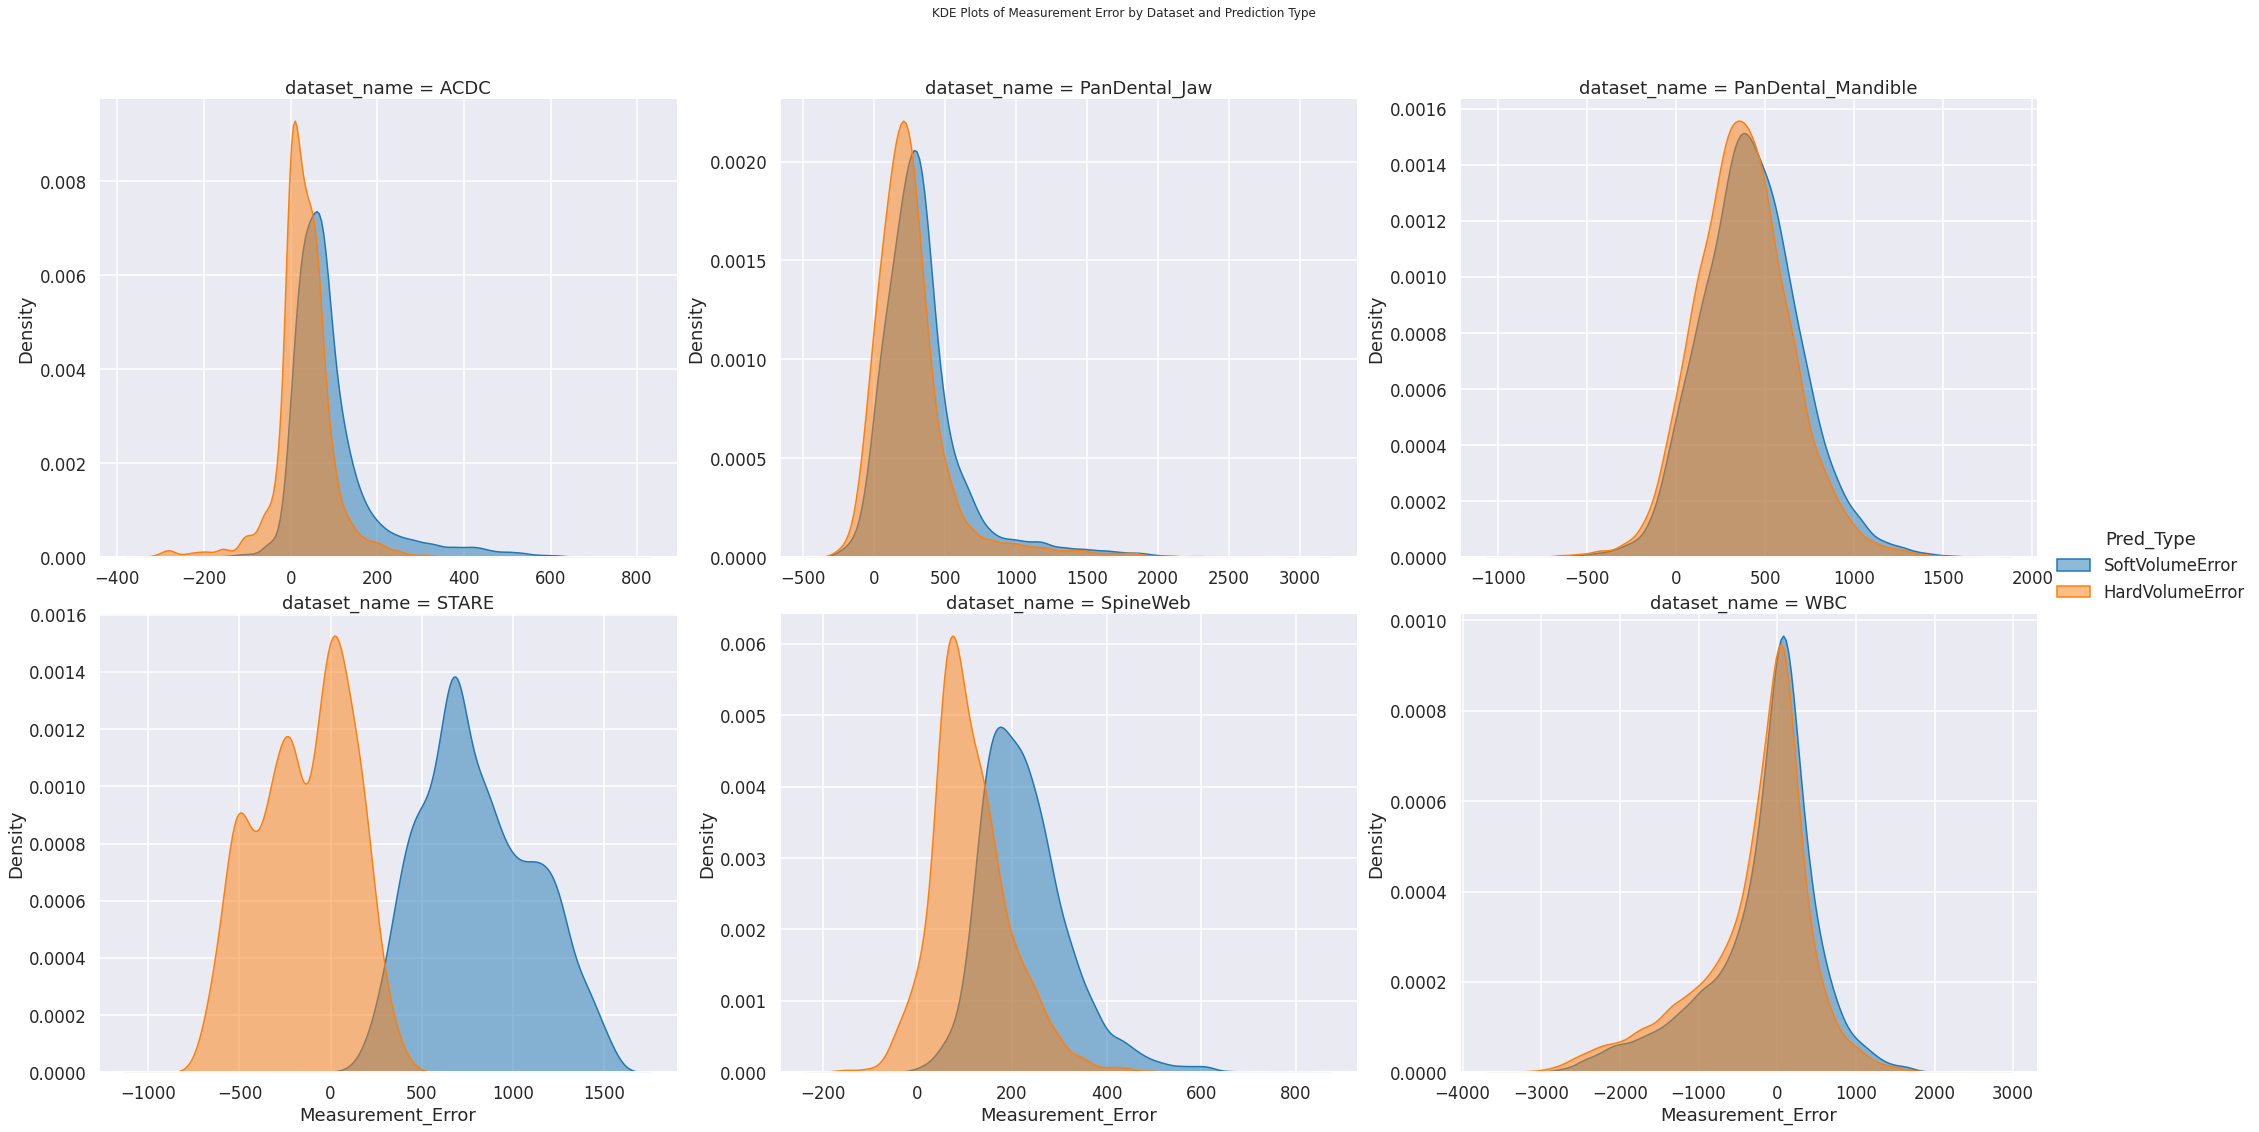

In [16]:
# Create a FacetGrid with dataset_name as columns
g = sns.FacetGrid(
    inference_df_piv_melted, 
    col='dataset_name', 
    col_wrap=3,
    hue='Pred_Type', 
    height=8, 
    aspect=1.2, 
    sharex=False, 
    sharey=False
)

# Map the KDE plot to the grid
g.map(sns.kdeplot, 'Measurement_Error', fill=True, alpha=0.5)

# Add a legend
g.add_legend()

# Adjust the layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('KDE Plots of Measurement Error by Dataset and Prediction Type')

# Show the plot
plt.show()